https://www.tensorflow.org/tutorials/keras/text_classification_with_hub

In [ ]:
!pip uninstall tensorflow

!pip install tensorflow==2.2.0

Uninstalling tensorflow-2.3.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.3.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 3.0MB 59.0MB/s 
     |████████████████████████████████| 460kB 55.4MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K

!pip install -q tensorflow-hub
!pip install -q tfds-nightly
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

     |████████████████████████████████| 3.5MB 2.8MB/s 
Version:  2.3.0
Eager mode:  True
Hub version:  0.9.0
GPU is NOT AVAILABLE


In [2]:
print("Version: ", tf.__version__)

Version:  2.3.0


In [3]:
data = pd.read_csv('/content/drive/My Drive/Máster KSchool/TFM/data/imdb_data.csv',usecols=['RATING','DESCRIPTION'])
data = data[data['DESCRIPTION']!="nodescription"]
data['DESCRIPTION'] = data['DESCRIPTION'].apply(lambda x: x.replace('(',''))
data['DESCRIPTION'] = data['DESCRIPTION'].apply(lambda x: x.replace(')',''))
data

,DESCRIPTION,RATING
0,When struggling rapper Coco Azealia Banks enro...,5.3
1,A man taking revenge on the killers of his loy...,6.4
2,The story of a young Viking boy who accompanie...,5.5
3,A dark fairy tale about a gang of five childre...,7.0
4,Four frames of simultaneous action that altern...,6.0
...,...,...
59620,Dazzling swordplay and eye-poping battles high...,5.3
59621,"Will Hunting, a janitor at M.I.T., has a gift ...",8.3
59622,One of only two survivors from a Martian exped...,5.3
59623,Is having fun and saying what you really think...,5.5


In [4]:
data['RATING']  = data['RATING'].astype(float)
data['RATING'] = pd.cut( data['RATING'], bins = [0, 5, 6.5, 10], labels=['0','1','2'])
data

,DESCRIPTION,RATING
0,When struggling rapper Coco Azealia Banks enro...,1
1,A man taking revenge on the killers of his loy...,1
2,The story of a young Viking boy who accompanie...,1
3,A dark fairy tale about a gang of five childre...,2
4,Four frames of simultaneous action that altern...,1
...,...,...
59620,Dazzling swordplay and eye-poping battles high...,1
59621,"Will Hunting, a janitor at M.I.T., has a gift ...",2
59622,One of only two survivors from a Martian exped...,1
59623,Is having fun and saying what you really think...,1


In [5]:
print(len(data[data['RATING']=='2']))
print(len(data[data['RATING']=='1']))
print(len(data[data['RATING']=='0']))

22080
25736
10930


In [6]:
X = data.DESCRIPTION.values
Y = data.iloc[:,[1]]

In [7]:
ency = OneHotEncoder(handle_unknown='ignore', sparse = False)
ency.fit(Y)
y_one_hot = ency.transform(Y)

In [8]:
x_train, x_test, y_train, y_test= train_test_split(X, y_one_hot, stratify=Y, test_size=0.2, random_state=22)

x_train = list(x_train)
x_test = list(x_test)

y_train = np.array(y_train).astype(int)
y_test = np.array(y_test).astype(int)

CREAMOS UNA MÉTRICA

In [9]:
def recall_class(y_true, y_pred, class_id):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)

    recall_mask = K.cast(K.equal(class_id_true, class_id), 'int32')
    class_recall_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * recall_mask
    class_recall = K.sum(class_recall_tensor) / K.maximum(K.sum(recall_mask), 1)

    return class_recall

def precision_class(y_true, y_pred, class_id):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)

    precision_mask = K.cast(K.equal(class_id_preds, class_id), 'int32')
    class_prec_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * precision_mask
    class_prec = K.sum(class_prec_tensor) / K.maximum(K.sum(precision_mask), 1)

    return class_prec

def f1_class(y_true, y_pred,class_id):

    class_prec = precision_class(y_true, y_pred, class_id)
    class_recall = recall_class(y_true, y_pred, class_id)
    class_f1 = 2*((class_prec*class_recall)/(class_prec+class_recall+K.epsilon()))

    return class_f1

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def custom_metric(y_true, y_pred):
  
  recall_0 = recall_class(y_true, y_pred, 0)
  f1_1 = f1_class(y_true, y_pred,1)
  precision_2 = precision_class(y_true, y_pred, 2)
  total_precision = precision(y_true, y_pred)

  metric = ((recall_0 + f1_1 + precision_2)/3)
  return metric

In [10]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
embedding2 = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
hub_layer = hub.KerasLayer(embedding2, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(x_train)

<tf.Tensor: shape=(46996, 20), dtype=float32, numpy=
array([[ 1.2197397 , -1.7124453 ,  0.93264455, ..., -1.6217961 ,
        -1.7296636 , -0.32061696],
       [ 1.4869866 , -1.2383468 ,  0.6305251 , ..., -0.6345606 ,
        -1.2890193 ,  0.0448238 ],
       [ 0.19561644, -1.6028581 ,  0.23661722, ..., -1.5002332 ,
        -1.9092529 , -0.46059367],
       ...,
       [ 0.7143508 , -0.7338139 ,  0.04399307, ..., -1.1194876 ,
        -3.3772256 , -0.15421502],
       [ 0.61097896, -0.08425026,  0.8603212 , ..., -0.07572454,
        -1.7049264 , -0.07456895],
       [ 1.37123   ,  0.18268555,  0.24896652, ..., -2.1117668 ,
        -1.9680028 ,  0.5705355 ]], dtype=float32)>

In [11]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(126, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                389380    
_________________________________________________________________
batch_normalization (BatchNo (None, 20)                80        
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 126)               3

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy',custom_metric])

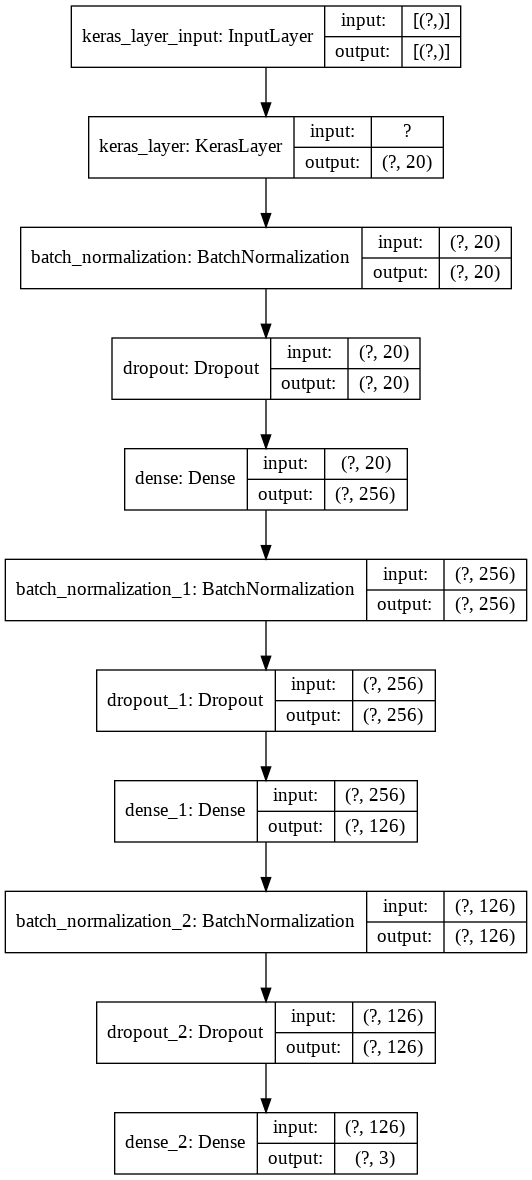

In [18]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image as printModel
plot_model(model, to_file='Multiinput.png',show_shapes=True,show_layer_names=True)
printModel(retina=True, filename='Multiinput.png')

In [19]:
plt.savefig('description.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size = 128, epochs = 30,
                    validation_data=(x_test, y_test),
                    verbose=1, class_weight = {0:10, 1:5, 2:4})

Epoch 1/30
368/368 [==============================] - 4s 10ms/step - loss: 7.2655 - accuracy: 0.3481 - custom_metric: 0.3921 - val_loss: 1.0774 - val_accuracy: 0.4367 - val_custom_metric: 0.4270
Epoch 2/30
368/368 [==============================] - 3s 9ms/step - loss: 6.0569 - accuracy: 0.3843 - custom_metric: 0.4291 - val_loss: 1.0755 - val_accuracy: 0.4411 - val_custom_metric: 0.4483
Epoch 3/30
368/368 [==============================] - 3s 9ms/step - loss: 6.0031 - accuracy: 0.4002 - custom_metric: 0.4441 - val_loss: 1.0790 - val_accuracy: 0.4259 - val_custom_metric: 0.5017
Epoch 4/30
368/368 [==============================] - 3s 9ms/step - loss: 5.9775 - accuracy: 0.4059 - custom_metric: 0.4552 - val_loss: 1.0702 - val_accuracy: 0.4369 - val_custom_metric: 0.4498
Epoch 5/30
368/368 [==============================] - 3s 9ms/step - loss: 5.9503 - accuracy: 0.4076 - custom_metric: 0.4622 - val_loss: 1.0667 - val_accuracy: 0.4343 - val_custom_metric: 0.4801
Epoch 6/30
368/368 [=========

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'custom_metric', 'val_loss', 'val_accuracy', 'val_custom_metric'])


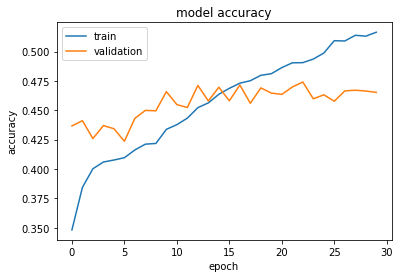

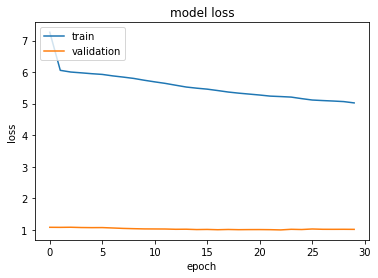

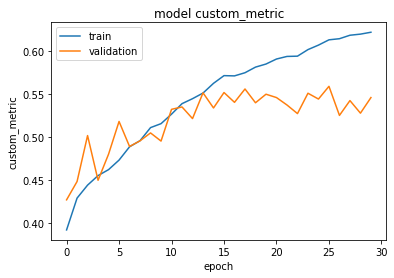

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['custom_metric'])
plt.plot(history.history['val_custom_metric'])
plt.title('model custom_metric')
plt.ylabel('custom_metric')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_pred= model.predict([x_test])

matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [ ]:
type(matrix)

numpy.ndarray

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 852  965  369]
 [1126 2597 1425]
 [ 611 1914 1891]]


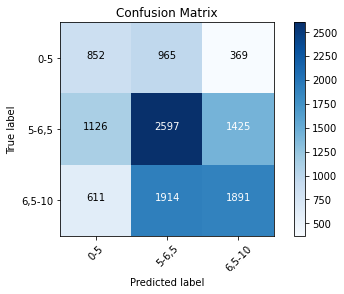

In [ ]:
cm_plot_labels = ['0-5','5-6,5', '6,5-10']
plot_confusion_matrix(cm=matrix, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
target_names = ['0-5', '5-6.5', '6.5-10']
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         0-5       0.33      0.39      0.36      2186
       5-6.5       0.47      0.50      0.49      5148
      6.5-10       0.51      0.43      0.47      4416

    accuracy                           0.45     11750
   macro avg       0.44      0.44      0.44     11750
weighted avg       0.46      0.45      0.46     11750



In [ ]:
model.predict(["Peaceful farmer Benjamin Martin is driven to lead the Colonial Militia during the American Revolution when a sadistic British officer murders his son."])

array([[0.13472086, 0.47111014, 0.394169  ]], dtype=float32)

In [ ]:
model.save('/tmp/model')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/model/assets


INFO:tensorflow:Assets written to: /tmp/model/assets
